In [87]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from models import MACAW
from utils.datasets import TorchDataset as TD

In [88]:
from PD.models import SFCN

mode = 'test'
test_block = 'flat'

model = SFCN().to('cuda')
checkpoint = torch.load('checkpoints/PD-SFCN/best_model.pt')
weights = checkpoint['model_state_dict']['fc1.weight'].data.cpu().numpy()
bias = checkpoint['model_state_dict']['fc1.bias'].data.cpu().numpy()

In [89]:
model = MACAW(nlatents=16).to('cuda')
checkpoint = torch.load('checkpoints/act-macaw-flat/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

data_loader = DataLoader(TD(f'/data/Data/PD/activations_{test_block}_{mode}'), batch_size=128, shuffle=False)

In [99]:
import numpy as np

obs = []
cfs = []
model.eval()
for b in data_loader:    
    x_obs, x_cf = model.counterfactuals(b.to('cuda'), cf_vals={0:0})
    obs.append(x_obs)
    cfs.append(x_cf)
    
obs = np.vstack(obs)
cfs = np.vstack(cfs)

In [100]:
obs_study = obs[:,0]
obs_sex = obs[:,1]
obs_scanner_type = obs[:,2]
obs_PD = obs[:,3]
obs_latents = obs[:,4:]

cf_study = cfs[:,0]
cf_sex = cfs[:,1]
cf_scanner_type = cfs[:,2]
cf_PD = cfs[:,3]
cf_latents = cfs[:,4:]

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

def joint_plot(pca_0 ,pca_1, col, name):
    fig = plt.figure(figsize=(4, 4))
    gs = fig.add_gridspec(4, 4, wspace=0, hspace=0)

    # Create the scatter plot and marginal axes
    ax_scatter = fig.add_subplot(gs[1:, :-1])
    ax_histx = fig.add_subplot(gs[0, :-1], sharex=ax_scatter)
    ax_histy = fig.add_subplot(gs[1:, -1], sharey=ax_scatter)

    sns.scatterplot(x=pca_0, y=pca_1, hue=col, palette='deep', alpha=0.6,
                    ax=ax_scatter, legend=False)
    cat = np.unique(col)
    for category, color in zip(cat, sns.color_palette()[:len(cat)]):
        mask = col == category
        sns.kdeplot(x=pca_0[mask], ax=ax_histx, color=color, fill=True, alpha=0.5, label=category)
        sns.kdeplot(y=pca_1[mask], ax=ax_histy, color=color, fill=True, alpha=0.5, label=category)

    ax_histx.set_ylabel('')
    ax_histx.set_title(name)
    ax_histy.set_xlabel('')

    ax_scatter.set_xlabel(f'PCA 0')
    ax_scatter.set_ylabel(f'PCA 1')

    ax_scatter.set_xticks([])
    ax_scatter.set_yticks([])

    ax_histx.grid(False)
    ax_histy.grid(False)

    ax_histx.set_xticks([])
    ax_histx.set_yticks([])

    ax_histy.set_xticks([])
    ax_histy.set_yticks([])

    plt.tight_layout()
    plt.show()

    return fig

def heatmap(data, title):
    # Seaborn 1D Heatmap
    plt.figure(figsize=(10, 1))
    sns.heatmap(data, cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [102]:
from sklearn.decomposition import PCA

pca = PCA(n_components=16)
obs_latent_pca = pca.fit_transform(obs_latents)
cf_latent_pca = pca.transform(cf_latents)

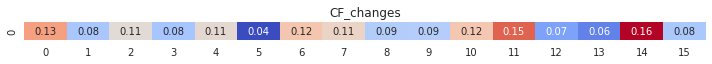

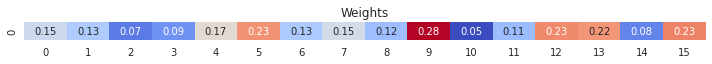

In [103]:
heatmap(np.mean(abs(cf_latents  - obs_latents), axis=0)[np.newaxis, :], 'CF_changes')
heatmap(abs(weights), 'Weights')

In [104]:
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def accuracy(y_true, y_pred, threshold=0.5):
    y_pred = y_pred > threshold
    return np.mean(y_pred == y_true)
    
obs_pred = sigmoid(obs_latents@weights.T + bias).squeeze()
obs_bce = BinaryCrossEntropy(obs_PD, obs_pred)
obs_accuracy=accuracy(obs_PD, obs_pred)
obs_bce,obs_accuracy

(0.59323287, 0.6885245901639344)

In [105]:
cf_pred = sigmoid(cf_latents@weights.T + bias).squeeze()
cf_bce = BinaryCrossEntropy(cf_PD, cf_pred)
cf_accuracy=accuracy(cf_PD, cf_pred)
cf_bce, cf_accuracy

(0.6222693, 0.6612021857923497)

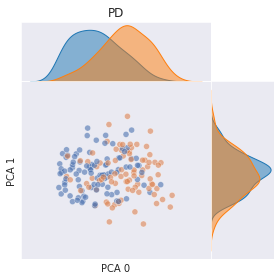

In [106]:
fig = joint_plot(obs_latent_pca[:,0], obs_latent_pca[:,1], obs_PD, 'PD')

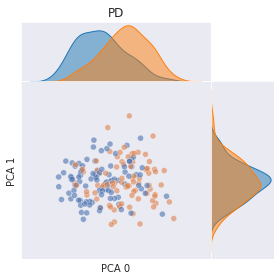

In [107]:
fig = joint_plot(cf_latent_pca[:,0], cf_latent_pca[:,1], obs_PD, 'PD')